In [1]:
from __future__ import print_function, division
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from PIL import Image

# 1.데이터 로드함수 작성

In [2]:
def getDevice():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

In [3]:
def getDatasetsWithClassNames(data_dir, batch_size, input_size= 224):
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size + 32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),}
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
                   for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    return dataloaders, class_names, data_transforms

# 2. 기존에 pretrain된 모델불러오기

In [4]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None    

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "resnet50":
        """ resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "resnet152":
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    elif model_name == "vgg19_bn":
        """ VGG19_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)        
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
    elif model_name == "densenet169":
        """ Densenet
        """
        model_ft = models.densenet169(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "densenet201":
        """ Densenet
        """
        model_ft = models.densenet201(pretrained=use_pretrained)        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)            
    elif model_name == "inception_v3":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)        
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

# 3. 모델 학습시키기

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    device = getDevice()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #print("--------------------")
                #print(inputs.shape)
                #print(labels.shape)
                #print(inputs)
                #print(labels)
                #print("--------------------")
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 4. 실제 모델별로 학습하기

In [13]:
def runmodel(model_name):    
    #model_name = "densenet201"
    #[resnet18, resnet50, resnet152, vgg19_bn, densenet169, densenet201, inception_v3]
    print("-------" * 10) 
    print("-------" * 10) 
    print("{} training started....".format(model_name) )
    print("-------" * 10) 
    print("-------" * 10) 
    
    #data_dir = 'D:\MyProject\PyTorch\InterBookRec\datas\mylocaltarget'
    data_dir = 'C:/Users/10008000/__ImageProcess/images/fortrain'
    
    num_classes = 818
    batch_size = 32
    num_epochs = 25
    feature_extract = False
    isInception = True if model_name.startswith("inception") else False
    input_size = 299 if isInception else 224

    dataloaders, class_names, data_transforms = getDatasetsWithClassNames( data_dir, batch_size, input_size )
    device = getDevice()    
    
    model_ft = initialize_model(model_name, num_classes, use_pretrained=True)    
    model_ft = model_ft.to(device)    

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    #print("before train_model")
    #return

    # first show image for test...
    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))
    print("type(inputs)", type(inputs), "type(classes)", type(classes))
    print("inputs.shape", inputs.shape, "classes.shape", classes.shape)
    
    print("classes[:4]", classes[:4])
    
    
    
    inputs =  inputs[:4,:,:,:]
    classes = classes[:4]
    
    
    
    

    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    

    model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=isInception )
    
    # save best model to file.
    PATH = "./{}_with_class_names_{}.pt".format(model_name, datetime.today().strftime("%Y%m%d"))
    torch.save({'model_state_dict':model_ft.state_dict(),'class_names':class_names}, PATH)
    
    # model inference 테스트 하기.
    checkpoint = torch.load(PATH)
    model_load = initialize_model(model_name, num_classes, use_pretrained=True)
    model_load.load_state_dict(checkpoint['model_state_dict'])
    model_load.eval()
    model_load = model_load.to('cpu')
    #filename = 'D:/MyProject/PyTorch/InterBookRec/datas/mylocaltarget/test/7734_40/0613144216_10_0.jpg'
    filename = 'C:/Users/10008000/__ImageProcess/images/fortrain/test/bear/00000106.jpg'
    imgdata = Image.open(filename)
    trans = data_transforms['val']
    img_trans = trans( imgdata ) 
    #img_trans = img_trans.to(device)

    outputs = model_load(img_trans.unsqueeze_(0))
    _, preds = torch.max(outputs, 1)
    print("preds.item()", preds.item())
    nIndex = preds.item()
    print("class_names", checkpoint["class_names"][nIndex])
    #print("class_names", class_names[nIndex])

# 5. 모델별로 함수를 실행하여 학습시키기

In [14]:
def main():
    # resnet test...
    #runmodel("resnet18")
    runmodel("resnet50")
    #runmodel("resnet152")
    
    # vgg test....
    #runmodel("vgg19_bn")
    
    # densenet test...
    #runmodel("densenet169")
    #runmodel("densenet201")
    
    # inception test...
    #runmodel("inception_v3")
    
    #print("all model is tested...")
    print("--------" * 10 )

# 6. main함수 실행하기

----------------------------------------------------------------------
----------------------------------------------------------------------
resnet50 training started....
----------------------------------------------------------------------
----------------------------------------------------------------------
type(inputs) <class 'torch.Tensor'> type(classes) <class 'torch.Tensor'>
inputs.shape torch.Size([32, 3, 224, 224]) classes.shape torch.Size([32])
classes[:4] tensor([6, 9, 3, 7])


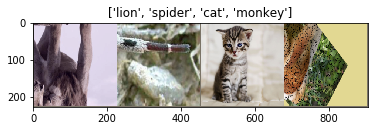

Epoch 0/24
----------
train Loss: 1.1008 Acc: 0.7609
val Loss: 0.2030 Acc: 0.9483

Epoch 1/24
----------
train Loss: 0.3935 Acc: 0.8761
val Loss: 0.1913 Acc: 0.9413

Epoch 2/24
----------
train Loss: 0.3162 Acc: 0.9006
val Loss: 0.1565 Acc: 0.9441

Epoch 3/24
----------
train Loss: 0.2983 Acc: 0.9046
val Loss: 0.1728 Acc: 0.9469

Epoch 4/24
----------
train Loss: 0.2791 Acc: 0.9086
val Loss: 0.1492 Acc: 0.9497

Epoch 5/24
----------
train Loss: 0.2433 Acc: 0.9256
val Loss: 0.1344 Acc: 0.9524

Epoch 6/24
----------
train Loss: 0.2317 Acc: 0.9245
val Loss: 0.1467 Acc: 0.9483

Epoch 7/24
----------
train Loss: 0.2269 Acc: 0.9259
val Loss: 0.1423 Acc: 0.9580

Epoch 8/24
----------
train Loss: 0.2095 Acc: 0.9311
val Loss: 0.1213 Acc: 0.9580

Epoch 9/24
----------
train Loss: 0.2149 Acc: 0.9336
val Loss: 0.1260 Acc: 0.9622

Epoch 10/24
----------
train Loss: 0.1934 Acc: 0.9376
val Loss: 0.1313 Acc: 0.9580

Epoch 11/24
----------
train Loss: 0.1806 Acc: 0.9444
val Loss: 0.1393 Acc: 0.9566

Ep

In [15]:
# run main
main()